# Convolutional Neural Network for Eye Diseases Classification

## Imports

In [47]:
import torch
import torchvision
import opendatasets as od
import wandb
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Data Loading and Exploration

In [48]:
od.download("https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification")

Skipping, found downloaded files in ".\eye-diseases-classification" (use force=True to force download)


In [49]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # We apply this for data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Using ImageNet statistics for future Transfer Learning
    ])

transform_test_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [50]:
full_dataset = torchvision.datasets.ImageFolder(root='eye-diseases-classification/dataset')

In [51]:
class TransformedSubset:
    def __init__(self, subset: Subset, transform: transforms.Compose):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index: int) -> tuple:
        img, label = self.subset[index]
        img = self.transform(img)
        return img, label
    
    def __len__(self) -> int:
        return len(self.subset)

In [52]:
np.random.seed(42)
index = np.arange(len(full_dataset))
np.random.shuffle(index)

train_percent = 0.8
test_val_percent = 0.1

train_index = int(train_percent * len(full_dataset))
test_val_index = int((train_percent + test_val_percent) * len(full_dataset))

dataset_train = TransformedSubset(Subset(full_dataset, index[:train_index]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, index[train_index:test_val_index]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, index[test_val_index:]), transform_test_val)

In [53]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

## Visualizate Images of Dataset

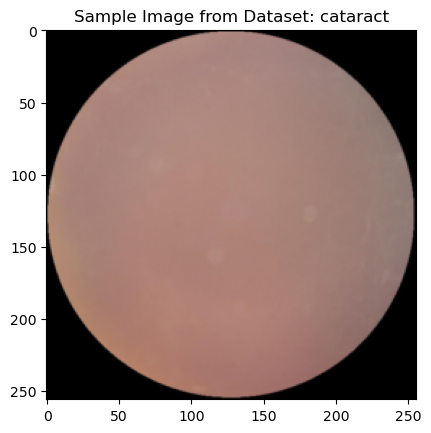

In [54]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
idx = random.randint(0, images.shape[0] - 1)
image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0)) # For matplotlib we need to change the shape

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean 
image = np.clip(image, 0, 1)

plt.title("Sample Image from Dataset: {class_name}".format(class_name=full_dataset.classes[labels[idx].item()]))
plt.imshow(image)
plt.show()

## Structure of Convolutional Neural Network

In [55]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        
        return x

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prove the Convolutional Neural Network

### Setup and Initialization of CNN

In [57]:
wandb.init(
    project="eye-disease-classification",
    name="custom_cnn_v1-3",
    config={
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 32,
        "architecture": "custom_cnn_4conv"
    }
)


In [58]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training, Validation and Testing of the CNN

In [59]:
epochs = 5
early_stopping_criteria = 15
early_stopping_counter = 0
best_val_loss = float('inf')
total_val_loss = []
total_train_loss = []
total_val_accuracy = []
total_training_accuracy = []


for epoch in range(epochs):

    # TRAIN
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    total_train_loss.append(train_loss)
    train_accuracy = 100 * train_correct / train_total
    total_training_accuracy.append(train_accuracy)
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    total_val_loss.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    total_val_accuracy.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_criteria:
        print(f'Early stopping at epoch {epoch+1}')
        break

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.2f}%')
    
    # Log in WanDB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

Epoch 1/5 - Train Loss: 2.4919, Train Acc: 36.23%, Val Loss: 1.1385, Val Acc: 50.71%
Epoch 2/5 - Train Loss: 1.1481, Train Acc: 48.03%, Val Loss: 0.9847, Val Acc: 51.42%
Epoch 3/5 - Train Loss: 1.0779, Train Acc: 50.28%, Val Loss: 0.9261, Val Acc: 59.72%
Epoch 4/5 - Train Loss: 1.0027, Train Acc: 53.66%, Val Loss: 0.8710, Val Acc: 65.17%
Epoch 5/5 - Train Loss: 0.9708, Train Acc: 54.73%, Val Loss: 0.9283, Val Acc: 57.58%


In [60]:
model.eval()
test_correct = 0
test_total = 0
y_pred = []
y_true = []

# TEST
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy of the model on test images: {test_accuracy:.2f}%')

wandb.log({"test_accuracy": test_accuracy})
wandb.finish()

Accuracy of the model on test images: 56.40%


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▅▆██
train_loss,█▂▁▁▁
val_accuracy,▁▁▅█▄
val_loss,█▄▂▁▂
epoch,5
test_accuracy,56.3981
train_accuracy,54.72873
train_loss,0.9708
val_accuracy,57.58294


## Graphics

### Confusion Matrix

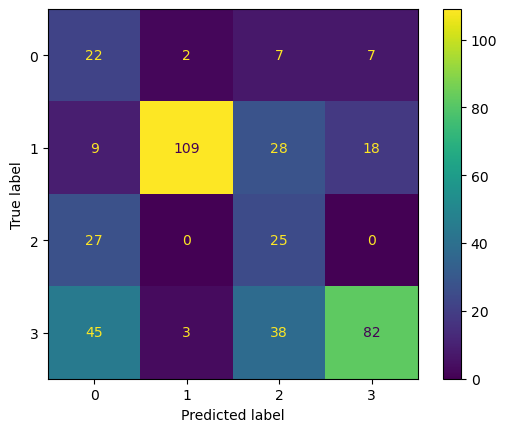

In [61]:
cm = confusion_matrix(y_pred, y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Loss And Accuraccy Graphics

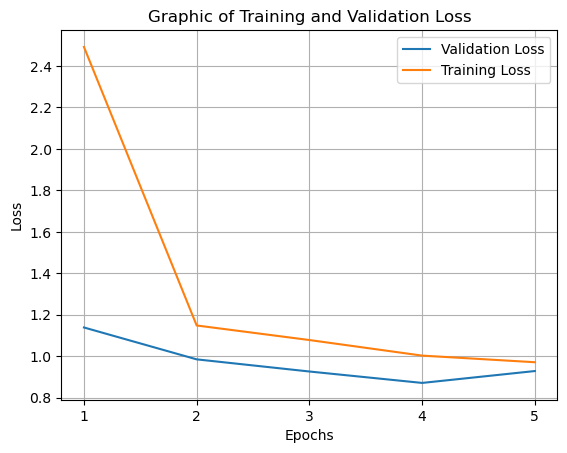

In [ ]:
plt.plot(range(1, epochs+1), total_val_loss, label='Validation')
plt.plot(range(1, epochs+1), total_train_loss, label='Training')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

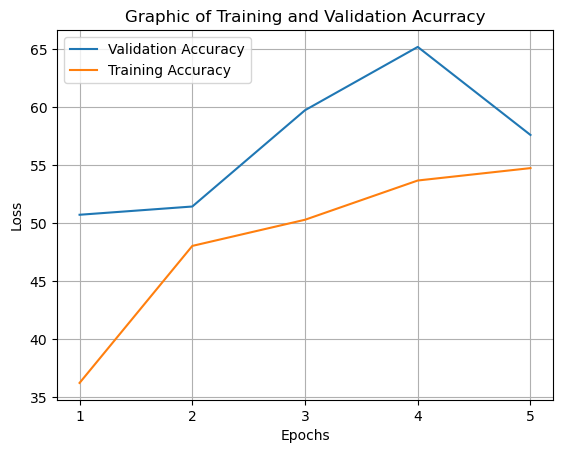

In [ ]:
plt.plot(range(1, epochs+1), total_val_accuracy, label='Validation')
plt.plot(range(1, epochs+1), total_training_accuracy, label='Training')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Acurracy')
plt.legend()
plt.grid()
plt.show()